# Import

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from tensorflow.keras import Model, layers, models, optimizers, regularizers
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed, Input
import seaborn as sns

In [2]:
# seed hold

random_seed = 42
SEED = 42
np.random.seed(random_seed)
import os
import random

import tensorflow as tf

random.seed(random_seed)


def set_seeds(seed=SEED):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)


def set_global_determinism(seed=SEED, fast_n_close=False):

    set_seeds(seed=seed)
    if fast_n_close:
        return
        logging.warning(
            "*******************************************************************************"
        )
        logging.warning(
            "*** set_global_determinism is called,setting full determinism, will be slow ***"
        )
        logging.warning(
            "*******************************************************************************"
        )
        os.environ["TF_DETERMINISTIC_OPS"] = "1"
        os.environ["TF_CUDNN_DETERMINISTIC"] = "1"
        # https://www.tensorflow.org/api_docs/python/tf/config/threading/set_inter_op_parallelism_threads
        tf.config.threading.set_inter_op_parallelism_threads(1)
        tf.config.threading.set_intra_op_parallelism_threads(1)
        from tfdeterminism import patch

        patch()


set_seeds()
set_global_determinism()

# Preprocess

## Load data

In [3]:
l1 = pd.read_csv('1_left.csv', index_col=0, parse_dates=['time'], infer_datetime_format=True)
r1 = pd.read_csv('1_right.csv', index_col=0, parse_dates=['time'], infer_datetime_format=True)
l2 = pd.read_csv('2_left.csv', index_col=0, parse_dates=['time'], infer_datetime_format=True)
r2 = pd.read_csv('2_right.csv', index_col=0, parse_dates=['time'], infer_datetime_format=True)

In [4]:
# 시간 정렬

l1.sort_values(by='time', inplace=True)
r1.sort_values(by='time', inplace=True)
l2.sort_values(by='time', inplace=True)
r2.sort_values(by='time', inplace=True)

In [5]:
l1.head()

,공정명,product,date,model_name,A,V,G,T,estimate,tip_cum,NUM(EA),time
2740,test robot01,1,2021-03-30,Unknown Model Name,54.2,20.51,7.17,6.7,NG_(A)(V)(T)(Tip),1,7,2021-03-30 12:12:34
2739,test robot01,2,2021-03-30,Unknown Model Name,54.2,20.63,7.17,6.7,NG_(A)(V)(T)(Tip),2,71,2021-03-30 12:12:48
2738,test robot01,3,2021-03-30,Unknown Model Name,54.1,20.50,7.17,6.7,NG_(A)(V)(T)(Tip),3,71,2021-03-30 12:13:03
2737,test robot01,4,2021-03-30,Unknown Model Name,54.2,20.65,7.17,6.8,NG_(A)(V)(T)(Tip),4,72,2021-03-30 12:13:18
2736,test robot01,5,2021-03-30,Unknown Model Name,54.2,20.64,7.17,6.7,GOOD,5,71,2021-03-30 12:13:33


In [6]:
l1['공정명'].value_counts()

PLASMA W/D 1호기     345459
test robot01         1125
PLASMA W/D LINE        16
Name: 공정명, dtype: int64

In [7]:
l1[l1['공정명'] == 'PLASMA W/D LINE']

,공정명,product,date,model_name,A,V,G,T,estimate,tip_cum,NUM(EA),time
1615,PLASMA W/D LINE,264,2021-03-31,Unknown Model Name,49.4,19.68,6.23,6.7,GOOD,1126,71,2021-03-31 09:48:29
1614,PLASMA W/D LINE,265,2021-03-31,Unknown Model Name,49.4,19.73,6.23,6.8,GOOD,1127,72,2021-03-31 09:48:44
1613,PLASMA W/D LINE,266,2021-03-31,Unknown Model Name,49.4,19.58,6.23,6.7,GOOD,1128,71,2021-03-31 09:48:59
1612,PLASMA W/D LINE,267,2021-03-31,Unknown Model Name,49.4,19.74,6.23,6.7,GOOD,1129,71,2021-03-31 09:49:13
1611,PLASMA W/D LINE,268,2021-03-31,Unknown Model Name,49.4,19.67,6.23,6.7,GOOD,1130,71,2021-03-31 09:49:30
1610,PLASMA W/D LINE,269,2021-03-31,Unknown Model Name,49.4,19.66,6.23,6.7,GOOD,1131,71,2021-03-31 09:49:44
1609,PLASMA W/D LINE,270,2021-03-31,Unknown Model Name,49.4,19.62,6.23,6.7,GOOD,1132,71,2021-03-31 09:49:59
1608,PLASMA W/D LINE,271,2021-03-31,Unknown Model Name,49.4,19.68,6.22,6.7,GOOD,1133,71,2021-03-31 09:50:14
1607,PLASMA W/D LINE,272,2021-03-31,Unknown Model Name,49.4,19.78,6.24,6.7,GOOD,1134,71,2021-03-31 09:50:29
1606,PLASMA W/D LINE,273,2021-03-31,Unknown Model Name,49.4,19.70,6.24,6.7,GOOD,1135,71,2021-03-31 09:50:44


In [8]:
l1[l1['공정명'] == 'test robot01']

,공정명,product,date,model_name,A,V,G,T,estimate,tip_cum,NUM(EA),time
2740,test robot01,1,2021-03-30,Unknown Model Name,54.2,20.51,7.17,6.7,NG_(A)(V)(T)(Tip),1,7,2021-03-30 12:12:34
2739,test robot01,2,2021-03-30,Unknown Model Name,54.2,20.63,7.17,6.7,NG_(A)(V)(T)(Tip),2,71,2021-03-30 12:12:48
2738,test robot01,3,2021-03-30,Unknown Model Name,54.1,20.50,7.17,6.7,NG_(A)(V)(T)(Tip),3,71,2021-03-30 12:13:03
2737,test robot01,4,2021-03-30,Unknown Model Name,54.2,20.65,7.17,6.8,NG_(A)(V)(T)(Tip),4,72,2021-03-30 12:13:18
2736,test robot01,5,2021-03-30,Unknown Model Name,54.2,20.64,7.17,6.7,GOOD,5,71,2021-03-30 12:13:33
...,...,...,...,...,...,...,...,...,...,...,...,...
1620,test robot01,259,2021-03-31,Unknown Model Name,49.4,19.70,6.23,6.7,GOOD,1121,71,2021-03-31 09:47:08
1619,test robot01,260,2021-03-31,Unknown Model Name,49.4,19.74,6.23,6.7,GOOD,1122,71,2021-03-31 09:47:23
1618,test robot01,261,2021-03-31,Unknown Model Name,49.4,19.59,6.24,6.7,GOOD,1123,71,2021-03-31 09:47:38
1617,test robot01,262,2021-03-31,Unknown Model Name,49.4,19.65,6.23,6.7,GOOD,1124,71,2021-03-31 09:47:53


In [9]:
# 1호기 left에서 공정명과 model_name 통일을 위해 3월 30일과 3월 31일 data drop
l1 = l1.drop(list(l1[(l1['date'] == '2021-03-30') | (l1['date'] == '2021-03-31')].index))

# index reset
l1.reset_index(drop=True, inplace=True)

# X, y make
y = l1['estimate']
X = l1.drop(['공정명', 'date', 'model_name', 'NUM(EA)', 'time', 'estimate'], axis=1)

In [10]:
print(X.shape)
print(y.shape)

(283502, 6)
(283502,)


<AxesSubplot:xlabel='A'>

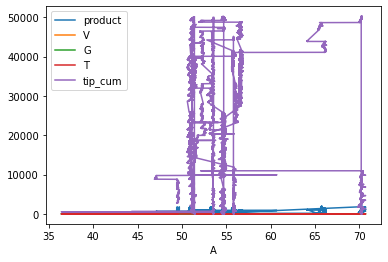

In [12]:
X.plot('A')

## train test split

In [11]:
# 약 70%인 12월 6일 기준 split
X_train= X[:199053]
y_train= y[:199053]
X_test= X[199053:]
y_train= y[199053:]

## Transform to sequence

In [12]:
step = 10

def trans_sequences(df, step):
    temp = []
    for i in range(len(df)-step+1):
        temp.append(df.iloc[i:(i+step)].values)
    
    return np.array(temp)

In [13]:
train_seq = trans_sequences(X_train, step)
test_seq = trans_sequences(X_test, step)

print(f'Training shape: {train_seq.shape}')
print(f'Testing shape: {test_seq.shape}')

Training shape: (199044, 10, 6)
Testing shape: (84440, 10, 6)


## feature scaling

In [14]:
train_seq_for_scale = train_seq.copy()
test_seq_for_scale = test_seq.copy()

train_number = train_seq_for_scale.shape[0]
feature_number = train_seq_for_scale.shape[2]
test_number = test_seq_for_scale.shape[0]

In [15]:
scaler = StandardScaler()

for i in range(step):
    scaler.partial_fit(train_seq_for_scale[:, i, :])

In [16]:
def scale(df, rows):
    scaled_array = []
    
    for i in range(step):
        scaled_array.append(scaler.transform(df[:, i, :]).reshape(rows, 1, feature_number))
    
    return np.concatenate(scaled_array, axis=1)

In [17]:
train_scaled = scale(train_seq_for_scale, train_number)
test_scaled = scale(test_seq_for_scale, test_number)

# Modeling

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10, 6)]           0         
                                                                 
 lstm (LSTM)                 (None, 10, 32)            4992      
                                                                 
 dropout (Dropout)           (None, 10, 32)            0         
                                                                 
 lstm_1 (LSTM)               (None, 16)                3136      
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 repeat_vector (RepeatVector  (None, 10, 16)           0         
 )                                                 

2022-05-18 14:25:43.073644: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-18 14:25:43.073781: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Trainable params: 16,710
Non-trainable params: 0
_________________________________________________________________


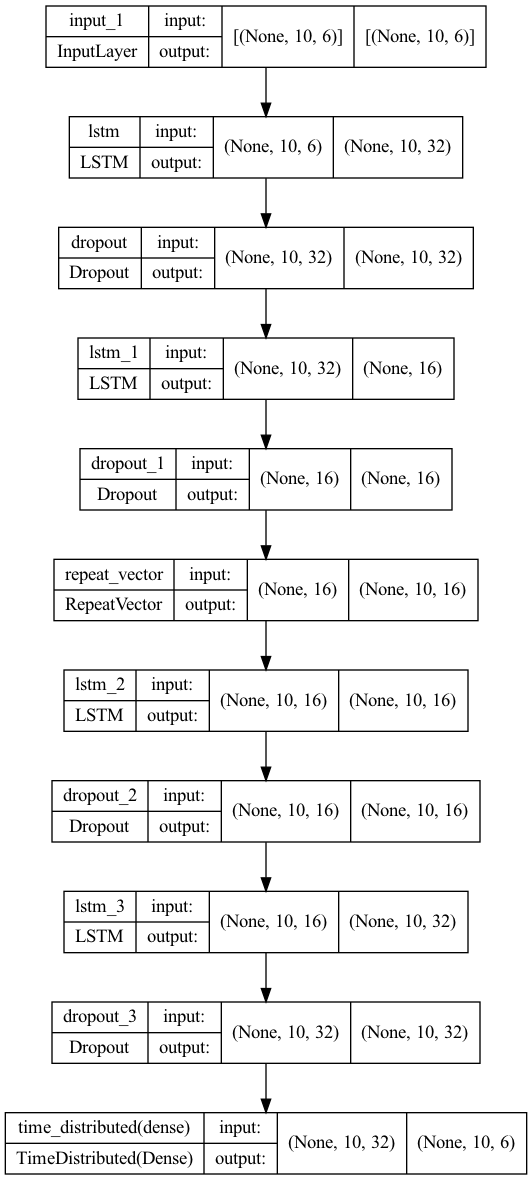

In [18]:
# encoder
pre_input = Input(shape=(step,feature_number))
encoder = LSTM(32, activation='swish', return_sequences=True)(pre_input)
encoder = Dropout(.1)(encoder)
encoder = LSTM(16, activation='swish', return_sequences=False)(encoder)
encoder = Dropout(.1)(encoder)

# reconstruct decoder
decoder1 = RepeatVector(step)(encoder)
decoder1 = LSTM(16, activation='swish', return_sequences=True)(decoder1)
decoder1 = Dropout(.1)(decoder1)
decoder1 = LSTM(32, activation='swish', return_sequences=True)(decoder1)
decoder1 = Dropout(.1)(decoder1)
decoder1 = TimeDistributed(Dense(feature_number))(decoder1)

# tie
lstm_autoencoder = Model(inputs=pre_input, outputs=decoder1)
lstm_autoencoder.summary()
lstm_autoencoder.compile(optimizer='adam', loss='mse')
plot_model(lstm_autoencoder, show_shapes=True)

In [19]:
# set parameter
epochs = 10
batch_size = 256
validation_split = 0.2
earlystop_patience = 2

In [20]:
# fit
history = lstm_autoencoder.fit(train_scaled, train_scaled, epochs=epochs, batch_size=batch_size, validation_split=validation_split,
                    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=earlystop_patience, mode='min')], shuffle=False)

Epoch 1/10


2022-05-18 14:25:48.450373: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-05-18 14:25:49.462898: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


623/623 [==============================] - ETA: 0s - loss: 0.8609

2022-05-18 14:32:05.102222: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


623/623 [==============================] - 385s 616ms/step - loss: 0.8609 - val_loss: 0.9106
Epoch 2/10
623/623 [==============================] - 392s 629ms/step - loss: 0.5743 - val_loss: 0.7987
Epoch 3/10
623/623 [==============================] - 464s 744ms/step - loss: 0.5192 - val_loss: 0.7411
Epoch 4/10
623/623 [==============================] - 472s 757ms/step - loss: 0.5101 - val_loss: 0.7303
Epoch 5/10
623/623 [==============================] - 508s 816ms/step - loss: 0.4969 - val_loss: 0.7270
Epoch 6/10
623/623 [==============================] - 509s 816ms/step - loss: 0.4129 - val_loss: 0.6251
Epoch 7/10
623/623 [==============================] - 462s 742ms/step - loss: 0.3480 - val_loss: 0.5502
Epoch 8/10
623/623 [==============================] - 461s 741ms/step - loss: 0.2878 - val_loss: 0.5174
Epoch 9/10
623/623 [==============================] - 461s 741ms/step - loss: 0.2566 - val_loss: 0.4502
Epoch 10/10
623/623 [==============================] - 463s 743ms/step - lo

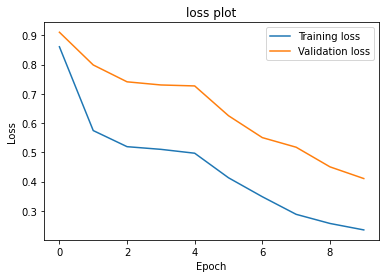

In [21]:
# loss plot
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend(loc='upper right')
plt.title('loss plot')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [23]:
# predict
train_predict = lstm_autoencoder.predict(train_scaled)

In [34]:
# anormaly
mse = np.mean(np.power(np.mean(train_predict-train_scaled, axis=1), 2), axis=1)
rmse = np.sqrt(np.mean(np.power(np.mean(train_predict-train_scaled, axis=1), 2), axis=1))

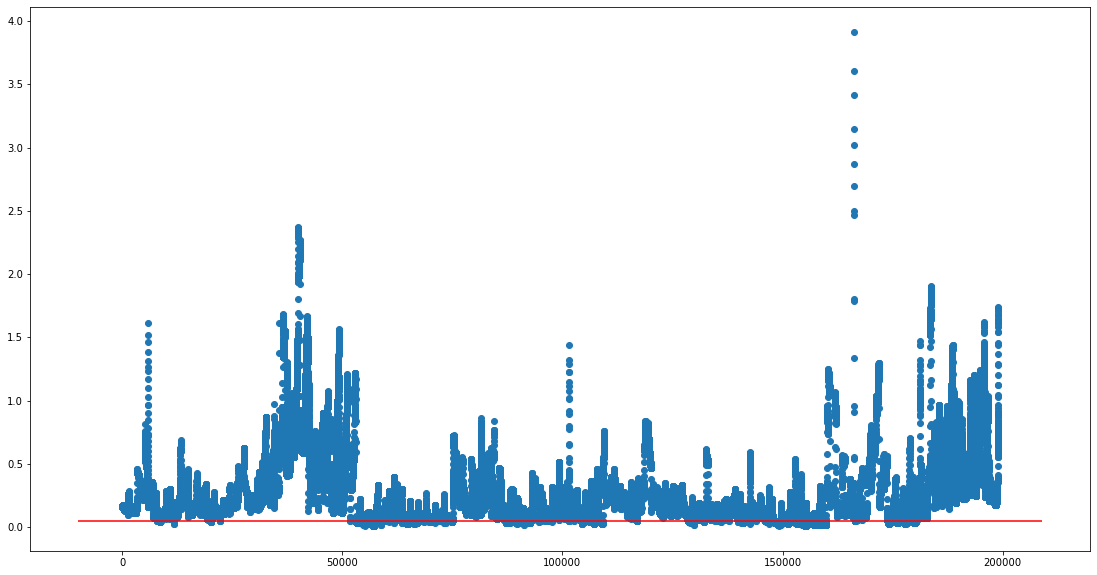

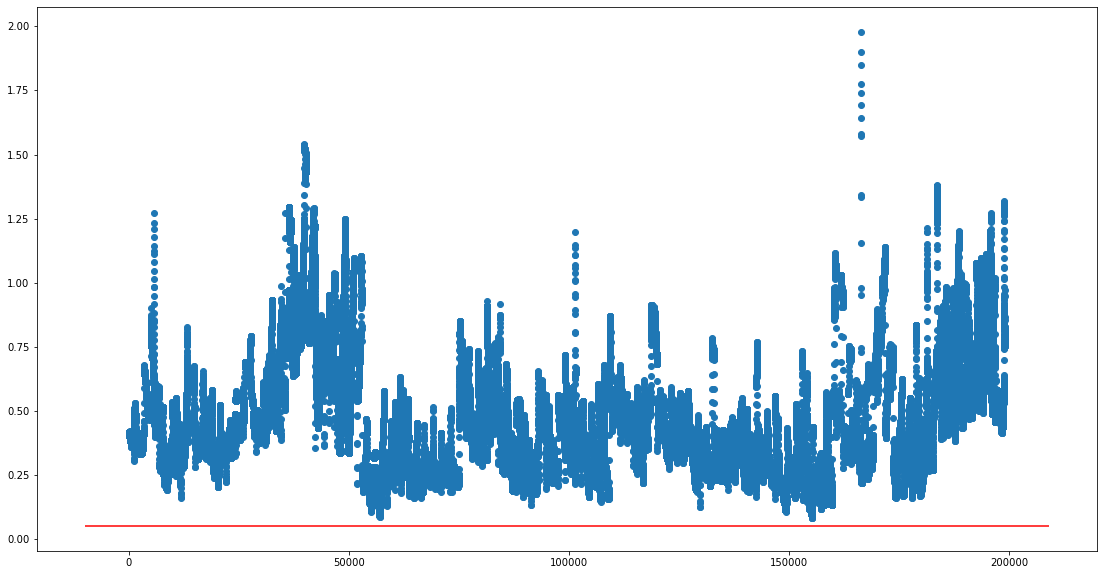

In [134]:
# set threshold & plot
threshold = 0.05

plt.figure(figsize=(19,10))
plt.scatter(pd.DataFrame(mse).index, mse)
ax = plt.subplot()
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')

plt.figure(figsize=(19,10))
plt.scatter(pd.DataFrame(rmse).index, rmse)
ax = plt.subplot()
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')

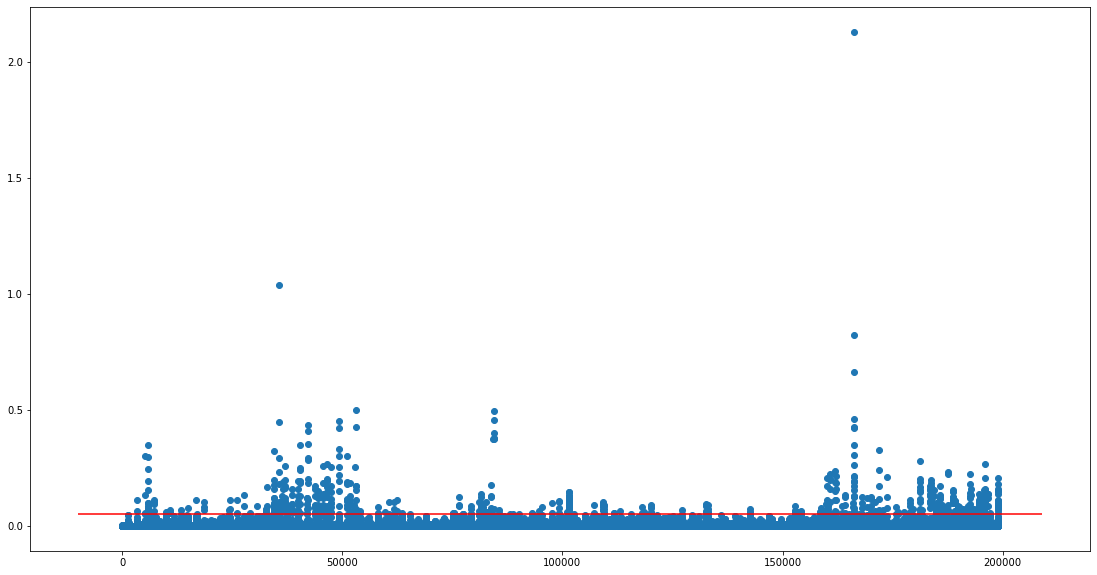

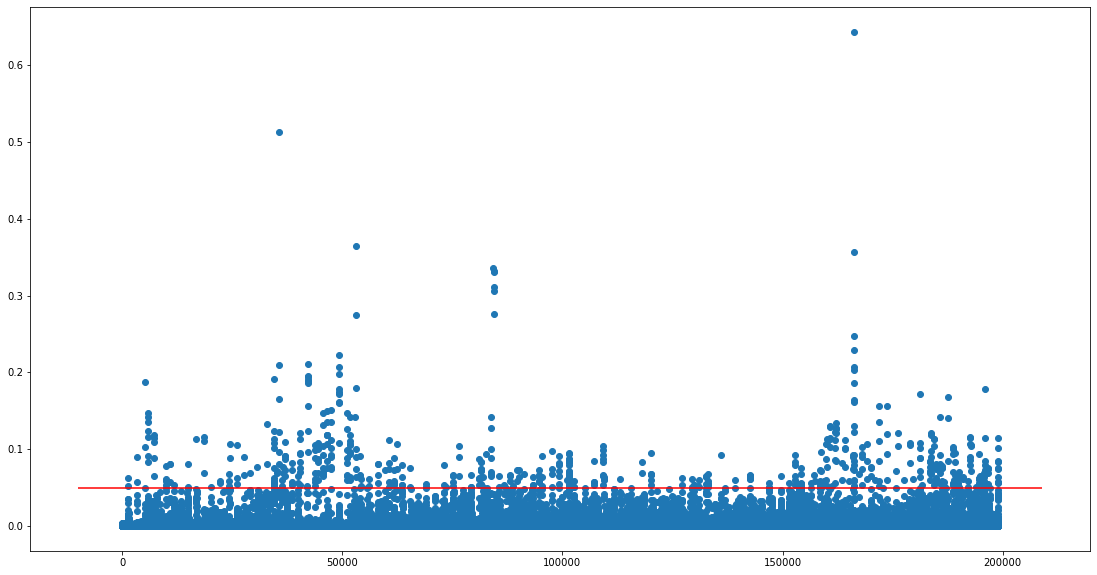

In [135]:
# set threshold & plot
plt.figure(figsize=(19,10))
plt.scatter(pd.DataFrame(mse).index, np.abs(pd.DataFrame(mse).diff()))
ax = plt.subplot()
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')

plt.figure(figsize=(19,10))
plt.scatter(pd.DataFrame(rmse).index, np.abs(pd.DataFrame(rmse).diff()))
ax = plt.subplot()
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')

In [136]:
# match anormaly flat
rmse_anormaly = list((np.abs(pd.DataFrame(rmse).diff()) > threshold)[0])
mse_anormaly = list((np.abs(pd.DataFrame(mse).diff()) > threshold)[0])

for _ in range(step - 1):
    rmse_anormaly.insert(0, rmse_anormaly[0])
    mse_anormaly.insert(0, mse_anormaly[0])

print(len(rmse_anormaly))
print(len(mse_anormaly))
print(X_train.shape)

199053
199053
(199053, 6)


In [137]:
# make check table
check_left = l1[:len(X_train)]
check_left['rmse_anormaly'] = rmse_anormaly
check_left['mse_anormaly'] = mse_anormaly
check_left.head()

/var/folders/qd/yc_92c9d2csclp39hh5l_t900000gn/T/ipykernel_6556/2908701566.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  check_left['rmse_anormaly'] = rmse_anormaly
/var/folders/qd/yc_92c9d2csclp39hh5l_t900000gn/T/ipykernel_6556/2908701566.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  check_left['mse_anormaly'] = mse_anormaly


,공정명,product,date,model_name,A,V,G,T,estimate,tip_cum,NUM(EA),time,rmse_anormaly,mse_anormaly
0,PLASMA W/D 1호기,1,2021-04-01,MAVERICK (RWD/FWD),49.5,20.47,5.85,6.7,GOOD,2742,71,2021-04-01 08:30:51,False,False
1,PLASMA W/D 1호기,2,2021-04-01,MAVERICK (RWD/FWD),49.4,20.43,5.86,6.7,GOOD,2743,71,2021-04-01 08:33:47,False,False
2,PLASMA W/D 1호기,3,2021-04-01,MAVERICK (RWD/FWD),49.4,20.32,5.91,6.7,GOOD,2744,71,2021-04-01 08:34:02,False,False
3,PLASMA W/D 1호기,4,2021-04-01,MAVERICK (RWD/FWD),49.4,20.31,5.99,6.8,GOOD,2745,72,2021-04-01 08:34:17,False,False
4,PLASMA W/D 1호기,5,2021-04-01,MAVERICK (RWD/FWD),49.4,20.36,5.90,6.7,GOOD,2746,71,2021-04-01 08:34:33,False,False


In [138]:
error_num = check_left.groupby(by='date')['rmse_anormaly'].sum().reset_index()
error_num[error_num['date'] == '2021-04-07']

,date,rmse_anormaly
6,2021-04-07,4


In [139]:
er = pd.read_csv('clean_db/error1.csv')
er['count'].max()

143.0